In [1]:
import os 
import math
import numpy as np
import pandas as pd

from concurrent.futures import as_completed, ThreadPoolExecutor
from tqdm.notebook import tqdm
from datetime import datetime

import wandb
import io
from PIL import Image as PILImage

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

from scipy.stats import pearsonr, spearmanr

import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader as TorchDataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR, CyclicLR

import torchmetrics
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, TQDMProgressBar, EarlyStopping, LearningRateFinder, LearningRateMonitor

from captum.attr import LayerGradCam, GuidedGradCam, IntegratedGradients, ShapleyValueSampling
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from collections import Counter

from torchviz import make_dot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
# Initialise wandb
os.environ["WANDB_NOTEBOOK_NAME"] = 'lightningCNN.ipynb'
wandb.init(project="lightningCNN", entity="rasmusfreund")

# Configure hyperparameters
config = wandb.config
config.learning_rate = 0.0003
config.num_epochs = 20
config.batch_size = 128

# Set up WandbLogger
wandb_logger = WandbLogger(name='lightningCNN_run', project='lightningCNN', log_model='all')

# Check for save-folder
current_date = datetime.now().strftime('%Y%m%d')
current_time = datetime.now().strftime('%H-%M')
base_path = '/faststorage/project/amr_driams/rasmus/CNNmodels'
if not os.path.isdir(os.path.join(base_path, current_date)):
    os.mkdir(os.path.join(base_path, current_date))

# Add callback
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(base_path, current_date),
    filename=f"best_checkpoint_{current_time}",
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
wandb.save(os.path.join(base_path, current_date), base_path=base_path)


wandb: Currently logged in as: rasmusfreund. Use `wandb login --relogin` to force relogin


['/faststorage/project/amr_driams/rasmus/wandb/run-20240506_085546-hocy42jv/files/20240506']

In [3]:
class DataLoader:
    def __init__(self, csv_file_path: str | list[str], data_dir_path: str | list[str], one_hot_encode: bool = True, training_target: str = 'species', num_workers: int = 5):
        """
        Initializes the DataLoader with paths to the csv file and the directory containing the actual data files.

        Parameters:
        csv_file_path: File path (or list of paths) to the CSV file(s) containing the references and labels.
        data_dir_path: Directory path (or list of paths) that contains the actual data files.
        one_hot_encode: True / False statement on whether to one-hot encode species labels
        training_target: Sets label output to either 'species' or 'resistance' depending on target of the model
        num_workers: Integer defining how many CPU cores are available for the data generator
        """
        self.csv_file_path = csv_file_path
        self.num_workers = num_workers
        
        # Control whether to one-hot encode labels
        self.one_hot_encode = one_hot_encode

        # Check target of the model
        if training_target not in ['species', 'resistance']:
            raise ValueError('Argument "training_target" should either be "species" or "resistance".')
        else:
            self.training_target = training_target
        
        # Get data references
        self.data_references = self._load_data_references(csv_file_path, data_dir_path)
        
        # Adjust file paths in data_references to include the correct directory
        self.data_references['file_path'] = self.data_references.apply(self.assign_file_path, axis=1)
            
        # Mapping for one-hot encoding of label-vectorx
        # Case: species
        if self.training_target == 'species':
            self.label_columns = ['species']
            self.label_mapping = {label: idx for idx, label in enumerate(self.data_references['species'].unique())}
        # Case: resistance
        else:
            self.label_columns = [col for col in self.data_references.columns if col not in ['code', 'species', 'source_csv', 'data_dir', 'file_path']]
        
        self.num_labels = len(self.data_references)

    def __len__(self):
        return len(self.data_references)
        
    
    def __getitem__(self, idx):
        data, label = self.load_data(idx)
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    
    def _load_data_references(self, csv_file_path, data_dir_path):
        data_frames = []
        if isinstance(csv_file_path, list):
            for path, dir_path in zip(csv_file_path, data_dir_path):
                df = pd.read_csv(path, low_memory=False)
                df['source_csv'] = path
                df['data_dir'] = dir_path
                data_frames.append(df)
        else:
            df = pd.read_csv(csv_file_path, low_memory=False)
            df['source_csv'] = csv_file_path
            df['data_dir'] = data_dir_path
            data_frames.append(df)
        
        return pd.concat(data_frames, ignore_index=True)

    
    def assign_file_path(self, row):
        """
        Assigns the correct file path based on the code and directory paths.
        """
        code = row['code']
        data_dir = row['data_dir']
        file_path = f'{data_dir}/{code}.txt'
        if not os.path.exists(file_path):
            return None
        return file_path

    
    def load_data(self, idx: int):
        """
        Loads a single data file based on the index provided and returns the contents and label.
        If target of the model is resistances, (R)esistant and (I)ntermediate will both be marked by 1, indicating resistance.

        Parameters:
        index: The index of the data file to load, as referenced in the CSV file.

        Returns:
        data, label pair         
        """
        row = self.data_references.iloc[idx]
        # Check if assign_file_path has returned None
        file_path = row['file_path']
        if file_path is None:
            # Skip loading this file and return None instead
            print(f"Warning: File for index {idx} not found. Skipping.")
            return None, None        
        data = self.convert_file_to_floats(row['file_path'])
        if not data:
            print(f'No loaded data from: {file_path}')
        label = None
        
        if self.training_target == 'resistance':
            label = row[self.label_columns].values.astype(int)
        else:        
            species_label = row['species']
            if self.one_hot_encode:
                label = np.zeros(self.num_labels)
                label[self.label_mapping[species_label]] = 1
            else:
                label = self.label_mapping[species_label]
            
        return data, label


    def convert_file_to_floats(self, file_path: str):
        data = [] # Container for converted data
        try:
            with open(file_path, 'r') as file:
                next(file) # Skip the header
                for line in file:
                    string_values = line.strip().split(',')[0]
                    if string_values == 'NA':
                        continue
                    else:
                        data.append(float(string_values))
        except Exception as e:
            print(f'Error processing file {file_path}: {e}')
        return data

    
    def one_hot_encode_label(self, label: str):
        one_hot_vector = np.zeros(self.num_labels)
        label_index = self.label_mapping[label]
        one_hot_vector[label_index] = 1
        
        return one_hot_vector


    def get_resistances_from_vector(self, k_hot_vector):
        if self.training_target != 'resistance':
            raise ValueError('This function is only applicable for resistance data.')
        active_indeces = [i for i, val in enumerate(k_hot_vector) if val == 1]
        active_resistances = [self.label_columns[i] for i in active_indeces]

        return active_resistances
    

    def data_generator(self):
        """
        Generator function that yields one data-label pair at a time; parallelised.
        """
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            future_to_idx = {executor.submit(self.load_data, idx): idx for idx in range(len(self.data_references))}
            for future in as_completed(future_to_idx):
                yield future.result()
    


In [4]:
class TorchDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = self.features[idx]
        sample = torch.tensor(sample, dtype=torch.float).unsqueeze(0)
        labels = self.labels[idx]
        labels = torch.tensor(labels, dtype=torch.float)
        return sample, labels

In [5]:
class maldiDataModule(L.LightningDataModule):
    def __init__(self, train_val_csv_path: str | list[str],
                 test_csv_file_path: str | list[str], 
                 data_dir_path: str | list[str], 
                 batch_size: int = 32, 
                 num_workers: int = 1, 
                 preprocess_paths: str | list[str] = "",
                 one_hot_encode: bool = False, 
                 training_target: str = 'resistance'
                ):
        super().__init__()
        self.train_val_csv_path = train_val_csv_path
        self.test_csv_file_path = test_csv_file_path
        self.data_dir_path = data_dir_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.one_hot_encode = one_hot_encode
        self.training_target = training_target
        self.preprocess_paths = preprocess_paths or []

        if self.preprocess_paths:
            self.load_preprocessed_data()
        else:
            self.load_and_preprocess_raw_data()

    def save_data_torch(self, X_train, y_train, X_test, y_test, label_columns, filepath='preprocessed_data.pt'):
        torch.save({'X_train': X_train, 
                    'y_train': y_train, 
                    'X_test': X_test, 
                    'y_test': y_test, 
                    'label_columns': label_columns
                   }, filepath, pickle_protocol=4)

    def load_and_preprocess_raw_data(self):
        # Load dataset for training / validation
        full_train_val_dataset = DataLoader(csv_file_path=self.train_val_csv_path, 
                                            data_dir_path=self.data_dir_path,
                                            one_hot_encode=self.one_hot_encode,
                                            training_target=self.training_target)
        
        self.label_columns = full_train_val_dataset.label_columns
        
        # Load dataset for testing
        self.test_dataset = DataLoader(csv_file_path=self.test_csv_file_path,
                                       data_dir_path=self.data_dir_path,
                                       one_hot_encode=self.one_hot_encode,
                                       training_target=self.training_target)
        
        X, y = [], []
        total_data_points = len(full_train_val_dataset.data_references)
        
        for data, label in tqdm(full_train_val_dataset.data_generator(), total=total_data_points, desc='Loading data'):
            if data is not None and label is not None:
                X.append(data)
                y.append(label)

        # Final sanity check of data
        X_filtered, y_filtered = [], []
        for data, label in zip(X, y):
            if type(data) == list and len(data) >= 36001:
                X_filtered.append(data)
                y_filtered.append(label)

        X, y = X_filtered, y_filtered
        
        X = np.array(X)
        y = np.array(y)
        
        X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)
        self.save_data_torch(X_train, y_train, X_test, y_test, self.label_columns)

        self.train_dataset = TorchDataset(X_train, y_train)
        self.val_dataset = TorchDataset(X_test, y_test)
    
    def load_preprocessed_data(self):
        X_train, y_train, X_test, y_test = [], [], [], []
        label_columns = None
        
        for path in self.preprocess_paths:
            data = torch.load(path)
            X_train.append(data['X_train'])
            y_train.append(data['y_train'])
            X_test.append(data['X_test'])
            y_test.append(data['y_test'])

            if label_columns is None:
                label_columns = data['label_columns']
            elif label_columns != data['label_columns']:
                raise ValueError(f"Label columns do not match for file {path}")

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        self.label_columns = label_columns
        self.train_dataset = TorchDataset(X_train, y_train)
        self.val_dataset = TorchDataset(X_test, y_test)
    
    
    
    def train_dataloader(self, shuffle=True):
        return TorchDataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=shuffle)

    def val_dataloader(self):
        return TorchDataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return TorchDataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
                                            

In [6]:
def plot_roc_curve(predictions: pd.DataFrame, labels: pd.DataFrame, max_classes_per_plot: int=15, save_path: str = None):
    """
    Plot ROC curve for each label.
    Parameters:
        predictions: DataFrame of label predictions (estimated probabilities, not classes) with shape of (n_sample, n_class).
        labels: DataFrame of ground truth labels with shape of (n_sample, n_class).
        max_classes_per_plot: Maximum number of classes to display in each subplot
    """
    n_classes = predictions.shape[1]
    n_plots = int(np.ceil(n_classes / max_classes_per_plot))
    colors = plt.colormaps['tab20b']
    lw = 2
    
    # Create subplots
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, n_plots * 5))
    if n_plots == 1:
        axes = [axes]

    for plot_idx in range(n_plots):
        start_idx = plot_idx * max_classes_per_plot
        end_idx = min((plot_idx + 1) * max_classes_per_plot, n_classes)

        for i in range(start_idx, end_idx):
            fpr, tpr, _ = roc_curve(labels.iloc[:, i], predictions.iloc[:, i])
            roc_auc = auc(fpr, tpr)
            color = colors(i - start_idx)

            axes[plot_idx].plot(fpr, tpr, color=color, lw=lw,
                                label=f'{predictions.columns[i]} (AUC = {roc_auc:.2f})')
        axes[plot_idx].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        axes[plot_idx].set_xlim([0.0, 1.0])
        axes[plot_idx].set_ylim([0.0, 1.05])
        axes[plot_idx].set_xlabel('False Positive Rate')
        axes[plot_idx].set_ylabel('True Positive Rate')
        axes[plot_idx].set_title(f'ROC curve for multilabel classification (Classes {start_idx+1} to {end_idx})')
        axes[plot_idx].legend(loc='upper left', bbox_to_anchor=(1,1))

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()


In [7]:
class ROCPlotCallback(Callback):
    def __init__(self, plot_func, save_path=None):
        """
        Parameters:
            plot_func: The function used for plotting ROC curves. This function should accept prediction and labels as input.
            save_path: Path to save the ROC plot. If None, the plot won't be saved.
        """
        super().__init__()
        self.plot_func = plot_func
        self.save_path = save_path
        self.label_columns = None

    def on_validation_epoch_end(self, trainer, pl_module):

        # Lazy loading of label columns
        if self.label_columns is None:
            self.label_columns = pl_module.trainer.datamodule.label_columns
        
        predictions = torch.cat(pl_module.val_predictions, dim=0)
        labels = torch.cat(pl_module.val_labels, dim=0)

        # Convert prediction and labels to numpy arrays
        predictions_np = predictions.detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()
        
        print(f"Predictions shape: {predictions_np.shape}, Labels shape: {labels_np.shape}")
        print(f"Expected columns count: {len(self.label_columns)}")

        if predictions_np.shape[1] != len(self.label_columns) or labels_np.shape[1] != len(self.label_columns):
             raise ValueError(f"Mismatch in columns: Expected {len(self.label_columns)}, got {predictions_np.shape[1]} for predictions and {labels_np.shape[1]} for labels")
        
        predictions_df = pd.DataFrame(predictions_np, columns=self.label_columns)
        labels_df = pd.DataFrame(labels_np, columns=self.label_columns)
            
        self.plot_func(predictions_df, labels_df)

        if self.save_path is not None:
            current_time = datetime.now().strftime('%H-%M')
            plt.savefig(os.path.join(self.save_path, f'ROC_curve_{current_time}'))
            plt.close()
        else:
            plt.show()

    def on_train_end(self, trainer, pl_module):
        if self.label_columns is None:
            self.label_columns = pl_module.trainer.datamodule.label_columns
        
        # Get full validation set
        val_dataloader = trainer.datamodule.val_dataloader()

        # Aggregate predictions and labels
        all_predictions = []
        all_labels = []
        for batch in val_dataloader:
            inputs, labels = batch
            inputs = inputs.to(pl_module.device)
            with torch.no_grad():
                predictions = pl_module(inputs)
            all_predictions.append(predictions)
            all_labels.append(labels)

        # Stack and convert to numpy
        all_predictions = pd.DataFrame(torch.cat(all_predictions).cpu().numpy(), columns=self.label_columns)
        all_labels = pd.DataFrame(torch.cat(all_labels).cpu().numpy(), columns=self.label_columns)

        # Generate ROC plot
        self.plot_func(pd.DataFrame(all_predictions), pd.DataFrame(all_labels))

        # Save plot
        if self.save_path:
            current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            plt.savefig(os.path.join(self.save_path, f'ROC_curve_full_validation_{current_time}.png'))
            plt.close()


In [8]:
# Alternative loss functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice_coeff


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.float32)
        at = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


class TverskyLoss(nn.Module):
    def __init__(self, alpha=1, beta=1, smooth=1):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()

        tversky_index = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        return (1 - tversky_index)


class FBetaloss(nn.Module):
    def __init__(self, beta=1.0, smooth=1e-6):
        super(FBetaloss, self).__init__()
        self.beta_squared = beta ** 2
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()

        precision = true_pos / (true_pos + false_pos + self.smooth)
        recall = true_pos / (true_pos + false_neg + self.smooth)

        fb_score = (1 + self.beta_squared) * (precision * recall) / (self.beta_squared * precision + recall + self.smooth)
        return (1 - fb_score.mean())


class MCC_Loss(nn.Module):
    """
    Calculates the proposed Matthews Correlation Coefficient-based loss.

    Args:
        inputs (torch.Tensor): 1-hot encoded predictions
        targets (torch.Tensor): 1-hot encoded ground truth
    """

    def __init__(self):
        super(MCC_Loss, self).__init__()

    def forward(self, inputs, targets):
        """
        MCC = (TP.TN - FP.FN) / sqrt((TP+FP) . (TP+FN) . (TN+FP) . (TN+FN))
        where TP, TN, FP, and FN are elements in the confusion matrix.
        """
        tp = torch.sum(torch.mul(inputs, targets))
        tn = torch.sum(torch.mul((1 - inputs), (1 - targets)))
        fp = torch.sum(torch.mul(inputs, (1 - targets)))
        fn = torch.sum(torch.mul((1 - inputs), targets))

        numerator = torch.mul(tp, tn) - torch.mul(fp, fn)
        denominator = torch.sqrt(
            torch.add(tp, 1, fp)
            * torch.add(tp, 1, fn)
            * torch.add(tn, 1, fp)
            * torch.add(tn, 1, fn)
        )

        # Adding 1 to the denominator to avoid divide-by-zero errors.
        mcc = torch.div(numerator.sum(), denominator.sum() + 1.0)
        return 1 - mcc

In [9]:
class maldiCNN(L.LightningModule):

    def __init__(self, classes, backbone, params, learning_rate):
        super().__init__()
        self.backbone = backbone(classes,
                                 cnn1_kernel=params['cnn1_kernel'],
                                 fc1_nodes=params['fc1_nodes'],
                                 dropout=params['dropout'])
        self.params = params
        self.learning_rate = learning_rate

        # Init lists to store predictions and labels
        self.val_predictions = []
        self.val_labels = []

        self.loss = self.get_loss_function()

        self.save_hyperparameters(ignore=['backbone'])

        self.train_ap = torchmetrics.classification.MultilabelAveragePrecision(num_labels=classes, average='weighted')
        self.val_ap = torchmetrics.classification.MultilabelAveragePrecision(num_labels=classes, average='weighted')
        self.test_ap = torchmetrics.classification.MultilabelAveragePrecision(num_labels=classes, average='weighted')
        
        self.train_f1 = torchmetrics.classification.MultilabelF1Score(num_labels=classes, average='macro')
        self.val_f1 = torchmetrics.classification.MultilabelF1Score(num_labels=classes, average='macro')
        self.test_f1 = torchmetrics.classification.MultilabelF1Score(num_labels=classes, average='macro')

        self.register_activation_hooks()

    def get_loss_function(self):
        if self.params['task'] == 'multiclass':
            return nn.CrossEntropyLoss()
        elif self.params['task'] in ['multilabel', 'binary']:
            return FBetaloss()
            #return F.binary_cross_entropy_with_logits
            #return FocalLoss()
            #return DiceLoss()
            #return TverskyLoss()
        else:
            raise ValueError(f'Unsupported task type: {self.params["task"]}')
    
    def forward(self, x):
        return self.backbone.forward(x)
    
    def register_activation_hooks(self):
        def get_activation(name):
            def hook(model, input, output):
                if model.training:
                    self.logger.experiment.log({f'{name}_activations': wandb.Histogram(output.detach().cpu().numpy())})
            return hook
        
        layer_names = ['conv1', 'convPool1', 'conv2', 'convPool2', 'fc0', 'fc1']
        for name in layer_names:
            layer = getattr(self.backbone, name, None)
            if layer is not None:
                layer.register_forward_hook(get_activation(name))
    
    def on_epoch_start(self):
        self.train_acc.reset()
        self.val_acc.reset()
        self.test_acc.reset()
    
    def on_validation_epoch_start(self):
        # Clear predictions and labels
        self.val_predictions = []
        self.val_labels = []

    def on_after_backward(self):
        # Hook for gradients; called after backward()
        for name, param in self.named_parameters():
            if param.grad is not None:
                grad = param.grad.cpu().detach()
                if model.training:
                    self.logger.experiment.log({f"{name}_grad": wandb.Histogram(grad.numpy())})

    def _shared_step(self, y_hat, y):
        loss = self.loss(y_hat, y)
        preds = torch.sigmoid(y_hat) if self.params['task'] in ['multilabel', 'binary'] else torch.softmax(y_hat, dim=1)
        return loss, preds, y.int()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss, preds, labels = self._shared_step(y_hat, y)
        
        self.train_ap(preds, labels)
        self.train_f1(preds, labels)
        self.log('train_loss', loss)
        self.log('train_AUPRC', self.train_ap, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_F1', self.train_f1, on_step=False, on_epoch=True, prog_bar = True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss, preds, labels = self._shared_step(y_hat, y)
        self.val_ap(preds, labels)
        self.val_f1(preds, labels)
        self.val_predictions.append(preds.detach())
        self.val_labels.append(labels.detach())
        self.log('val_loss', loss)
        self.log('val_AUPRC', self.val_ap, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_F1', self.val_f1, on_step=False, on_epoch=True, prog_bar = True, logger=True)
        return loss

    def test_step(self, batch):
        x, y = batch
        y_hat, feature_maps = self(x)
        
        loss, preds, labels = self._shared_step(batch)
        self.test_acc(preds, labels)
        self.test_f1(preds, labels)
        self.log('test_loss', loss)
        self.log('test_AUPRC', self.test_ap, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_F1', self.test_f1, on_step=False, on_epoch=True, prog_bar = True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=6, gamma=0.3)
            
        return [optimizer], [scheduler]
        

In [10]:
class backboneCNN(nn.Module):
    def __init__(self, num_classes, cnn1_kernel, fc1_nodes, dropout):
        super().__init__()

        self.cnn1_kernel = cnn1_kernel
        self.fc1_nodes = fc1_nodes
        self.dropout = dropout
        self.num_classes = num_classes
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 8, kernel_size=self.cnn1_kernel, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(8)
        self.convPool1 = nn.Conv1d(8, 8, 10, stride=10)
        self.bnPool1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=self.cnn1_kernel, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(16)
        self.convPool2 = nn.Conv1d(16, 16, 10, stride=10)
        self.bnPool2 = nn.BatchNorm1d(16)

        # Fully connected layers
        self.fc0 = nn.Linear(5760, self.fc1_nodes)
        self.fc1 = nn.Linear(self.fc1_nodes, num_classes)

        # Dropout and activation functions
        self.dropout = nn.Dropout(self.dropout)
        self.activation = nn.modules.SiLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.convPool1(x)
        x = self.bnPool1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.convPool2(x)
        x = self.bnPool2(x)
        x = self.activation(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.activation(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        return self.sigmoid(x)


In [12]:
L.seed_everything(42)

train_files = ['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv',
               '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2016_clean_filtered_train_val.csv',
               '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2017_clean_filtered_train_val.csv',
               '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_filtered_train_val.csv']

test_files = ['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_test.csv',
              '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2016_clean_test.csv',
              '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2017_clean_test.csv',
              '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_test.csv']

data_paths = ['/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2015/',
              '/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2016/',
              '/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2017/',
              '/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2018/']

preprocessed_data = ['/faststorage/project/amr_driams/rasmus/preprocessed_data_2015.pt',
                     '/faststorage/project/amr_driams/rasmus/preprocessed_data_2016.pt',
                     '/faststorage/project/amr_driams/rasmus/preprocessed_data_2017.pt',
                     '/faststorage/project/amr_driams/rasmus/preprocessed_data_2018.pt']

train_file = '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_filtered_train_val.csv'
test_file = '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_filtered_test.csv'
data_path = '/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2018/'


data_module = maldiDataModule(train_val_csv_path=train_files,
                              test_csv_file_path=test_files,
                              data_dir_path=data_paths,
                              num_workers=4,
                              batch_size=wandb.config.batch_size,
                              preprocess_paths=preprocessed_data
                             )
parameters = {
    'cnn1_kernel': 8,
    'fc1_nodes': 2880,
    'dropout': 0.5,
    'task': 'multilabel'
}

# Log parameters
wandb_logger.log_hyperparams(parameters)

# Initialize model
model = maldiCNN(backbone = backboneCNN,
                 learning_rate = wandb.config.learning_rate,
                 classes = (len(pd.read_csv(train_file).columns) - 2),
                 params = parameters)



# Callbacks
early_stopping = EarlyStopping(patience=10, monitor="val_loss")
roc_plot_callback = ROCPlotCallback(plot_roc_curve, 
                                    save_path=os.path.join(base_path, current_date))

# Training
trainer = Trainer(logger=wandb_logger,
                  callbacks=[checkpoint_callback, roc_plot_callback],
                  max_epochs=config.num_epochs)
trainer.fit(model, datamodule=data_module)

[rank: 0] Seed set to 42
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/rfreund/miniforge3/envs/amr/lib/python3.11/sit ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /faststorage/project/amr_driams/rasmus/CNNmodels/20240504 exists and is not empty.

  | Name     | Type                       | Params
--------------------------------------------------------
0 | backbone | backboneCNN                | 16.7 M
1 | loss     | FBetaloss                  | 0     
2 | train_ap | MultilabelAveragePrecision | 0 

Sanity Checking: |                              | 0/? [00:00<?, ?it/s]

/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Predictions shape: (256, 27), Labels shape: (256, 27)
Expected columns count: 27


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |                                     | 0/? [00:00<?, ?it/s]

Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 0, global step 558: 'val_loss' reached 0.92600 (best 0.92600), saving model to '/faststorage/project/amr_driams/rasmus/CNNmodels/20240504/best_checkpoint_11-20.ckpt' as top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 1, global step 1116: 'val_loss' reached 0.92592 (best 0.92592), saving model to '/faststorage/project/amr_driams/rasmus/CNNmodels/20240504/best_checkpoint_11-20.ckpt' as top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 2, global step 1674: 'val_loss' reached 0.92591 (best 0.92591), saving model to '/faststorage/project/amr_driams/rasmus/CNNmodels/20240504/best_checkpoint_11-20.ckpt' as top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 3, global step 2232: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 4, global step 2790: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 5, global step 3348: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 6, global step 3906: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 7, global step 4464: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 8, global step 5022: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 9, global step 5580: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 10, global step 6138: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 11, global step 6696: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 12, global step 7254: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 13, global step 7812: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 14, global step 8370: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 15, global step 8928: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 16, global step 9486: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 17, global step 10044: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 18, global step 10602: 'val_loss' was not in top 1
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in weighted-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                   | 0/? [00:00<?, ?it/s]

Predictions shape: (17857, 27), Labels shape: (17857, 27)
Expected columns count: 27


Epoch 19, global step 11160: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
print(torch.cuda.is_available())

False


In [11]:
parameters = {
    'cnn1_kernel': 15,
    'fc1_nodes': 2880,
    'dropout': 0.5,
    'task': 'multilabel'
}

# Log parameters
wandb_logger.log_hyperparams(parameters)

train_file = '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_filtered_train_val.csv'

# Initialize model
model = maldiCNN(backbone = backboneCNN,
                 learning_rate = wandb.config.learning_rate,
                 classes = (len(pd.read_csv(train_file).columns) - 2),
                 params = parameters)

checkpoint = torch.load('FBeta-SiLU_model.ckpt', map_location=torch.device('cpu'))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.to(device)

/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


maldiCNN(
  (backbone): backboneCNN(
    (conv1): Conv1d(1, 8, kernel_size=(15,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convPool1): Conv1d(8, 8, kernel_size=(10,), stride=(10,))
    (bnPool1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(8, 16, kernel_size=(15,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convPool2): Conv1d(16, 16, kernel_size=(10,), stride=(10,))
    (bnPool2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc0): Linear(in_features=5760, out_features=2880, bias=True)
    (fc1): Linear(in_features=2880, out_features=27, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): SiLU()
    (sigmoid): Sigmoid()
  )
  (loss): FBetaloss()
  (train_ap): MultilabelAveragePrecision()
  (val_ap): MultilabelAver

In [12]:
# Data to visualize

# Paths to .csv files
csv_files = ['/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv',
             '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2016_clean_filtered_train_val.csv',
             '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2017_clean_filtered_train_val.csv',
             '/faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2018_clean_filtered_train_val.csv']

# Columns representing antibiotics
antibiotic_columns = ["Imipenem", "Gentamicin", "Oxacillin", "Fusidic acid", "Tetracycline", "Rifampicin",
                      "Amoxicillin-Clavulanic acid", "Cefazolin", "Meropenem", "Ciprofloxacin", "Levofloxacin",
                      "Teicoplanin", "Norfloxacin", "Cotrimoxazole", "Tobramycin", "Ampicillin-Amoxicillin",
                      "Ceftriaxone", "Ceftazidime", "Clindamycin", "Penicillin", "Cefuroxime", "Cefpodoxime",
                      "Fosfomycin-Trometamol", "Colistin", "Erythromycin", "Cefepime", "Piperacillin-Tazobactam"]

def get_top_combinations(data_paths, antibiotic_columns, top_n=5):
    # Initialize counters for all combinations
    combinations_counter = Counter()

    # Read and process files
    for file_path in data_paths:
        data = pd.read_csv(file_path)
        labels = data[antibiotic_columns].to_numpy()

        # Get combination matrix and count each combination
        combinations = get_combination_wise_output_matrix(labels, order=5)
        combinations_counter.update(str(combination) for row in combinations for combination in row)
    # Find the top N most common combinations
    top_combinations = combinations_counter.most_common(top_n)

    # Dictionary to store sample data for each top combination
    selected_samples = {comb: pd.DataFrame() for comb, _ in top_combinations}
    
    # Collect data for each top combination
    for file_path in data_paths:
        data = pd.read_csv(file_path)
        labels = data[antibiotic_columns].to_numpy()
        
        for comb, _ in top_combinations:
            # Parse the combination indices from the string
            indices = eval(comb)
            # Create a boolean mask for the rows matching the exact combination
            mask = np.zeros_like(labels, dtype=bool)
            mask[:, indices] = True
            condition = (data[antibiotic_columns] == mask).all(axis=1)
            filtered_data = data[condition]

            # Collect a sample of this combination
            if not filtered_data.empty:
                if selected_samples[comb].empty:
                    selected_samples[comb] = filtered_data
                else:
                    selected_samples[comb] = pd.concat([selected_samples[comb], filtered_data])

    return selected_samples, top_combinations
                

In [13]:
selected_samples = {}

for file_path in csv_files:
    data = pd.read_csv(file_path)

    # Iterate over each antibiotic
    for antibiotic in antibiotic_columns:
        if antibiotic not in selected_samples:
            # Ensure only one column has '1' and all others are '0'
            condition = (data[antibiotic_columns].sum(axis=1) == 1) & (data[antibiotic] == 1)
            filtered_data = data[condition]

            # If there are any suitable rows, select the first one
            if not filtered_data.empty:
                selected_samples[antibiotic] = filtered_data.iloc[0]
                print(f"Found a sample for {antibiotic} in {file_path}")

if len(selected_samples) == len(antibiotic_columns):
    print("Found at least one sample for each antibiotic.")
else:
    missing = set(antibiotic_columns) - set(selected_samples.keys())
    print(f"Missing samples for the following antibiotics: {missing}")

Found a sample for Oxacillin in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Tetracycline in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Rifampicin in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Amoxicillin-Clavulanic acid in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Ciprofloxacin in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Levofloxacin in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Cotrimoxazole in /faststorage/project/amr_driams/rasmus/data/DRIAMS-A/id/resistance/2015_clean_filtered_train_val.csv
Found a sample for Tobramycin in /fa

In [13]:
selected_samples, top_combinations = get_top_combinations(csv_files, antibiotic_columns)


In [14]:
def load_spectrum_data(code):
    files2015 = os.listdir('/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2015')
    files2016 = os.listdir('/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2016')
    if f"{code}.txt" in files2015:
        file_path = f"/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2015/{code}.txt"
    elif f"{code}.txt" in files2016:
        file_path = f"/faststorage/project/amr_driams/data/DRIAMS-A/preprocessed_raw/2016/{code}.txt"
    else:
        print(f"File for code {code} not found.")
        return None
        
    data = [] # Container for converted data
    try:
        with open(file_path, 'r') as file:
            next(file) # Skip the header
            for line in file:
                string_values = line.strip().split(',')[0]
                if string_values == 'NA':
                    continue
                else:
                    data.append(float(string_values))
    except Exception as e:
            print(f'Error processing file {file_path}: {e}')
    return data

In [22]:
def plot_attributions(attributions, spectrum_data, title, zoom_range = None, save_path = None):
    attributions = attributions.cpu().detach().numpy().squeeze()
    spectrum_data = spectrum_data.cpu().detach().numpy().squeeze()

    # Normalize attributions for colormap instensity
    max_attribution = np.max(np.abs(attributions))
    norm = mcolors.Normalize(vmin=-max_attribution, vmax=max_attribution)
    colors = plt.cm.viridis(norm(attributions))
    
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[10, .2], height_ratios=[1, 2], hspace=0.25, wspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])
    
    mz_range = np.linspace(2000, 20000, num=len(spectrum_data))

    # Top plot for attributions
    ax1.plot(mz_range, attributions)
    ax1.set_title(f'Feature Importance for {title}')
    ax1.set_ylabel('Importance')
    ax1.set_xlabel('Mass (m/z)')
    ax1.set_xlim([2000, 20000])

    if zoom_range:
        ax1.set_xlim(zoom_range)

    # Bottom plot for original spectrum with heatmap
    ax2.plot(mz_range, spectrum_data, color='black', linewidth=1)
    ax2.set_title('Original Spectrum with Feature Importance Heatmap')
    ax2.set_ylabel('Spectrum Intensity')
    ax2.set_xlabel('Mass (m/z)')
    ax2.set_xlim([2000, 20000])

    if zoom_range:
        ax2.set_xlim(zoom_range)

    x = np.linspace(2000, 20000, num=len(spectrum_data)+1)
    y = np.linspace(spectrum_data.min(), spectrum_data.max(), 11)
    z = attributions[np.newaxis, :].repeat(10, axis=0)
    
    mesh = ax2.pcolormesh(x, y, z, norm=norm, cmap='seismic', shading='flat')

    fig.colorbar(mesh, cax=cax, orientation='vertical', label='Importance')
    
    if save_path:
        plt.savefig(f'{save_path}/{title}.png', dpi=300)
    plt.show()


Skipping Oxacillin as it already exists
Skipping Tetracycline as it already exists
Skipping Rifampicin as it already exists
Skipping Amoxicillin-Clavulanic acid as it already exists
Skipping Ciprofloxacin as it already exists
Skipping Levofloxacin as it already exists
Skipping Cotrimoxazole as it already exists
Tobramycin


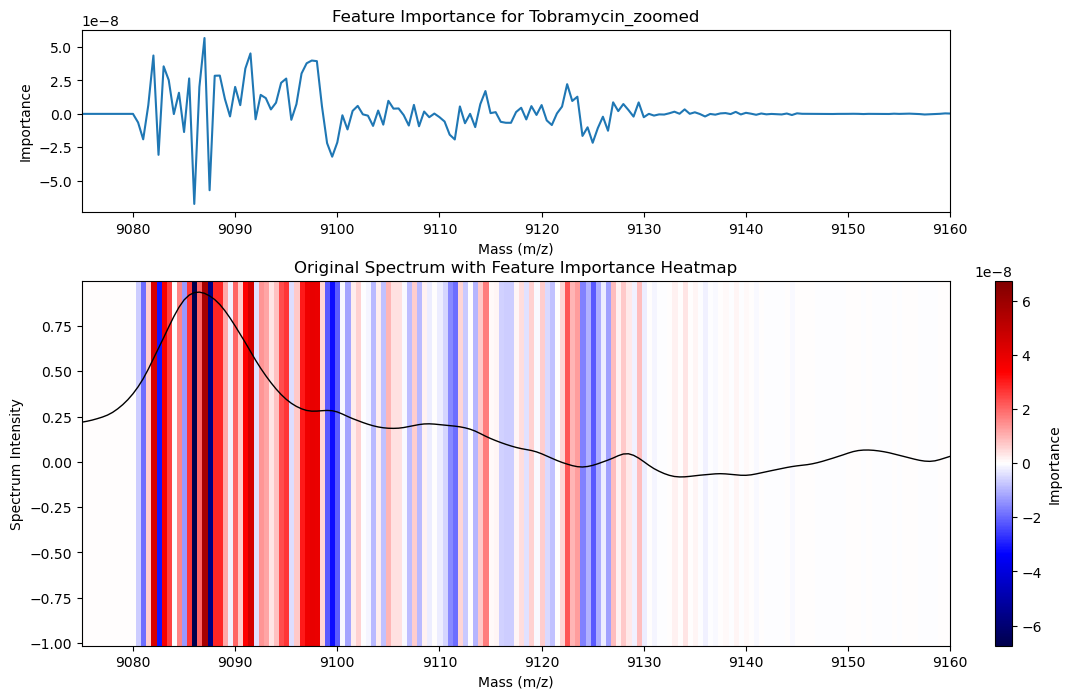

Skipping Ampicillin-Amoxicillin as it already exists
Skipping Ceftriaxone as it already exists
Skipping Penicillin as it already exists
Skipping Fosfomycin-Trometamol as it already exists
Skipping Colistin as it already exists
Skipping Cefepime as it already exists
Skipping Piperacillin-Tazobactam as it already exists
Skipping Imipenem as it already exists
Skipping Gentamicin as it already exists
Skipping Fusidic acid as it already exists
Skipping Meropenem as it already exists
Skipping Ceftazidime as it already exists
Skipping Clindamycin as it already exists
Skipping Cefuroxime as it already exists
Skipping Cefpodoxime as it already exists
Skipping Erythromycin as it already exists


In [30]:
# Plotting for single antibiotic resistance
target_layer = model.backbone.conv2

for antibiotic, sample in selected_samples.items():
    if antibiotic in ["Imipenem", "Gentamicin", "Oxacillin", "Fusidic acid", "Tetracycline", "Rifampicin",
                      "Amoxicillin-Clavulanic acid", "Cefazolin", "Meropenem", "Ciprofloxacin", "Levofloxacin",
                      "Teicoplanin", "Norfloxacin", "Cotrimoxazole", "Ampicillin-Amoxicillin",
                      "Ceftriaxone", "Ceftazidime", "Clindamycin", "Penicillin", "Cefuroxime", "Cefpodoxime",
                      "Fosfomycin-Trometamol", "Colistin", "Erythromycin", "Cefepime", "Piperacillin-Tazobactam"]:
        print(f'Skipping {antibiotic} as it already exists')
        continue
    print(antibiotic)
    spectrum_data = load_spectrum_data(sample['code'])
    spectrum_data = torch.tensor(spectrum_data).unsqueeze(0).unsqueeze(0)
    spectrum_data = spectrum_data.to(device)

    target_index = antibiotic_columns.index(antibiotic)

    grad_cam = GuidedGradCam(model, target_layer)
    attributions = grad_cam.attribute(spectrum_data, target=target_index)

    #svs = ShapleyValueSampling(model)
    #attributions = svs.attribute(spectrum_data, target=target_index)

    # Save attributions
    numpy_attributions = attributions.detach().cpu().numpy()
    save_path = f'/faststorage/project/amr_driams/rasmus/Figures/features/gradCAM'
    if os.path.isfile(os.path.join(save_path, f'{antibiotic}.png'):
        raise RuntimeError(f'Filepath "{save_path}" already exists.\nDelete the file before running this script again.')
    np.save(save_path, numpy_attributions)
    
    plot_attributions(attributions, spectrum_data, f'{antibiotic}', save_path = save_path)

['Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-0., -0., 0.,  ..., -0., -0., -0.]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


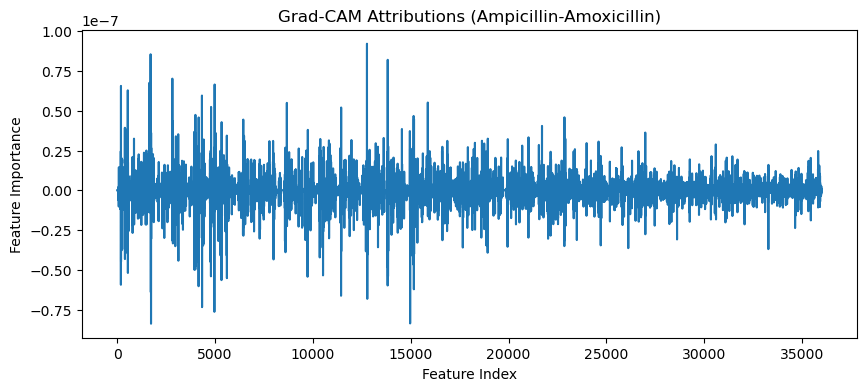

['Amoxicillin-Clavulanic acid']
torch.Size([1, 1, 36001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


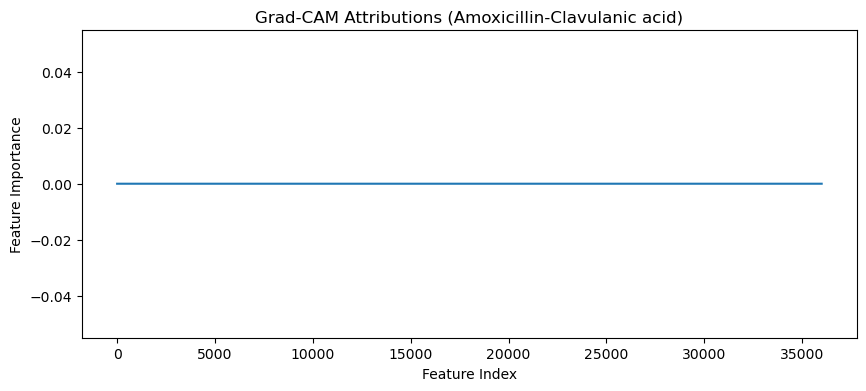

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


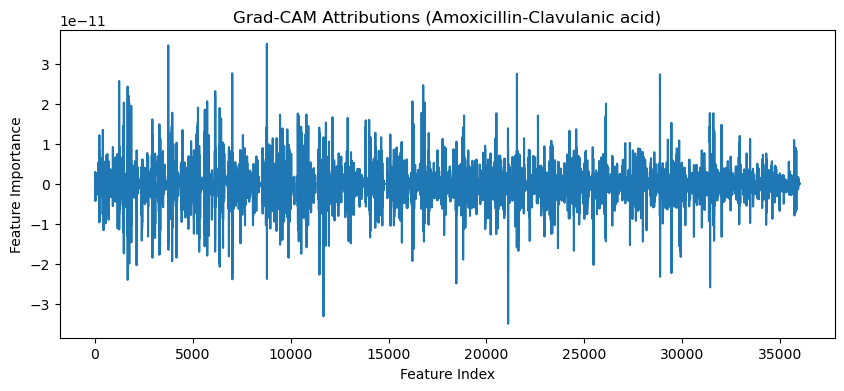

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


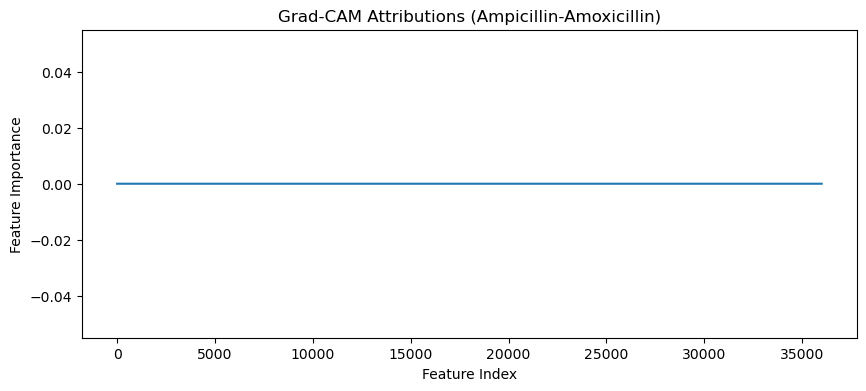

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


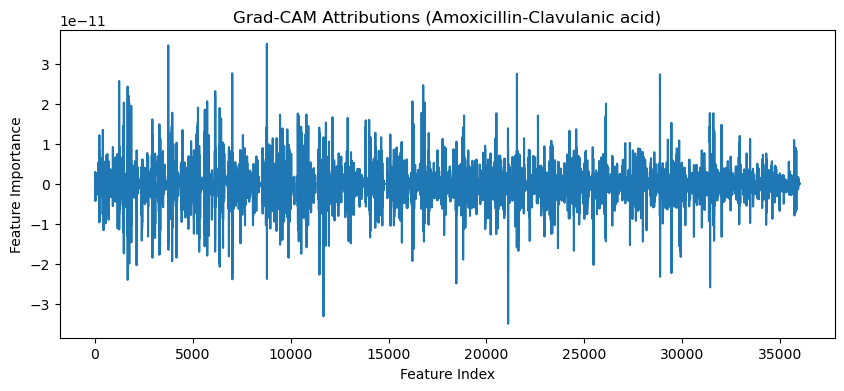

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


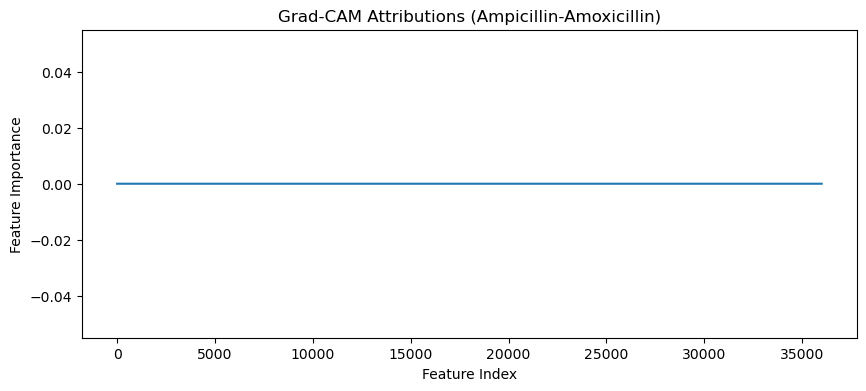

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


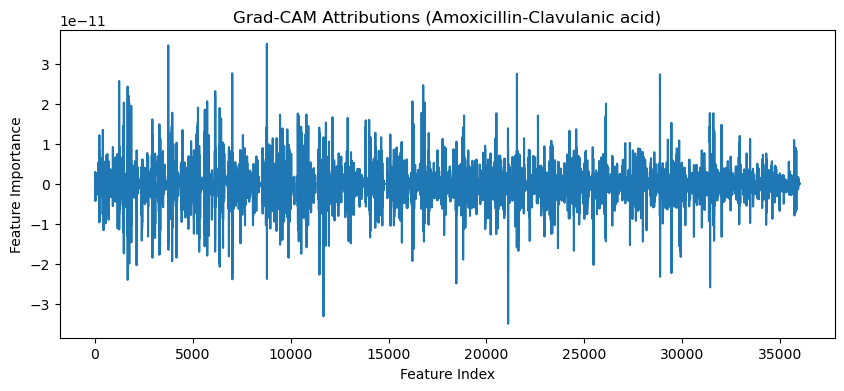

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


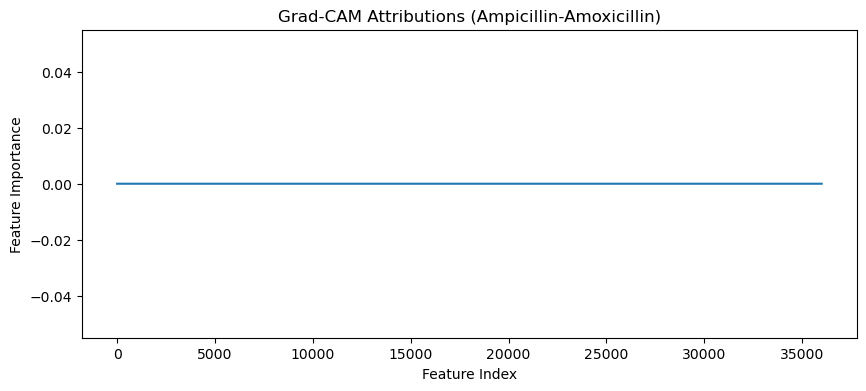

In [20]:
# Captum methods for combinatorial data
target_layer = model.backbone.conv2
    
for combination, sample_df in selected_samples.items():
    plotted = False
    for index, row in sample_df.iterrows():
        if plotted:
            break
            
        code = row['code']
        antibiotics = [antibiotic_columns[idx] for idx, val in enumerate(row[antibiotic_columns]) if val == 1]
        if not antibiotics:
            continue

        spectrum_data = load_spectrum_data(code)
        if spectrum_data is None:
            continue
        
        spectrum_data = torch.tensor(spectrum_data, dtype=torch.float).unsqueeze(0).unsqueeze(0)
        spectrum_data = spectrum_data.to(device)

        grad_cam = GuidedGradCam(model, layer=target_layer)
        
        for antibiotic in antibiotics:
            target_index = antibiotic_columns.index(antibiotic)
    
            gradcam_attributions = grad_cam.attribute(spectrum_data, target=target_index)
            print(gradcam_attributions)
    
            plot_attributions(gradcam_attributions, f'Grad-CAM Attributions ({antibiotic})')
        plotted = True
    

['Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-0., -0., 0.,  ..., -0., -0., -0.]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


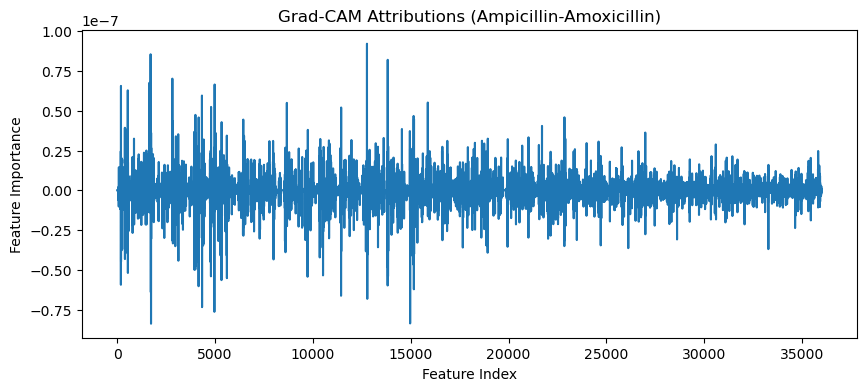

['Amoxicillin-Clavulanic acid']
torch.Size([1, 1, 36001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


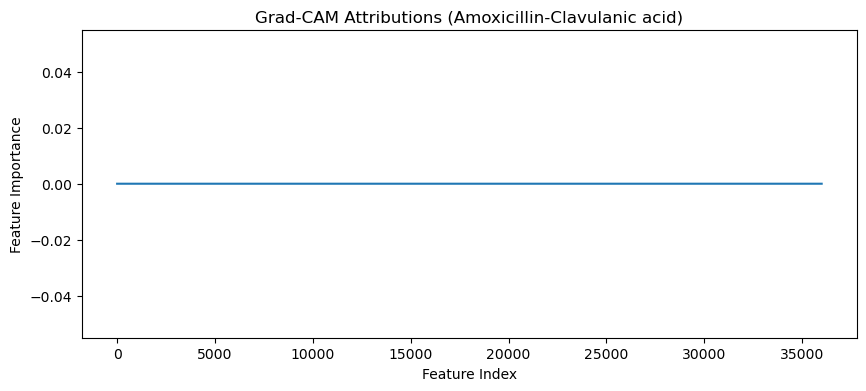

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


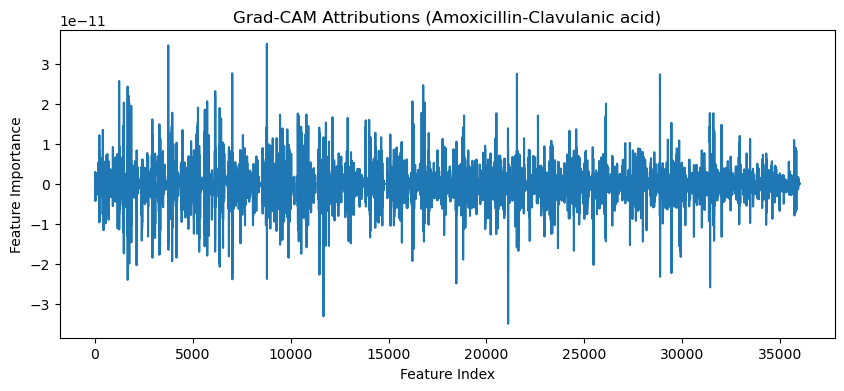

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


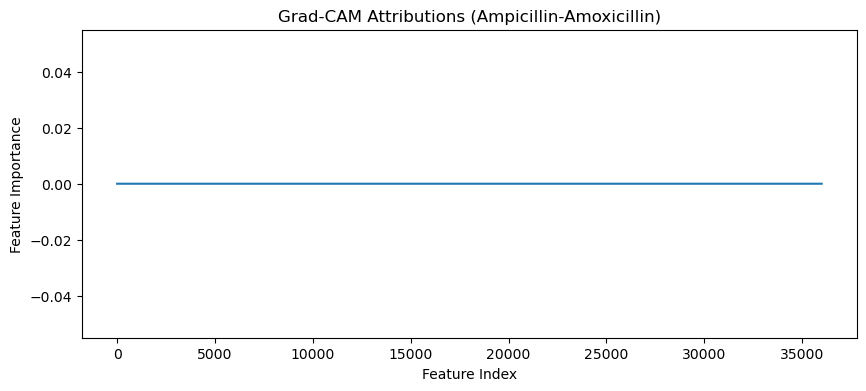

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


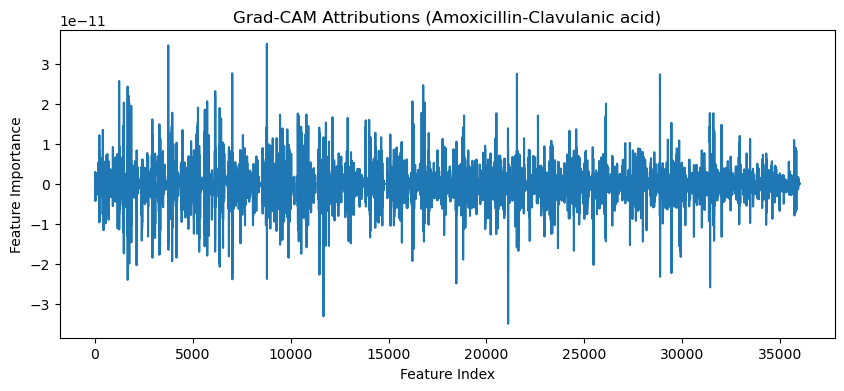

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


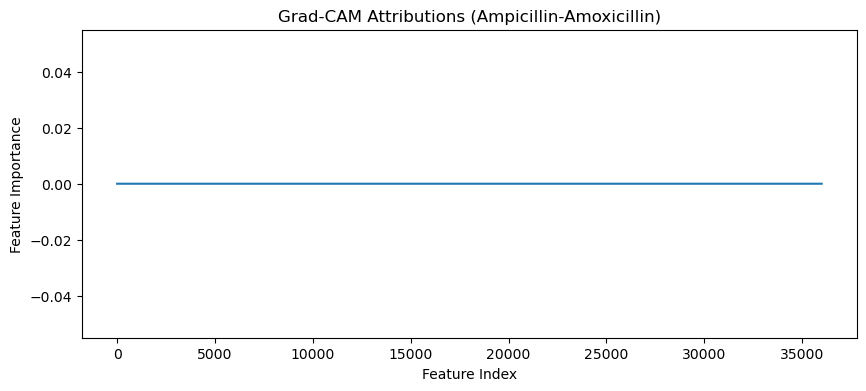

['Amoxicillin-Clavulanic acid', 'Ampicillin-Amoxicillin']
torch.Size([1, 1, 36001])
tensor([[[-1.1305e-12, -1.0009e-12,  6.7691e-14,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]], grad_fn=<MulBackward0>)


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


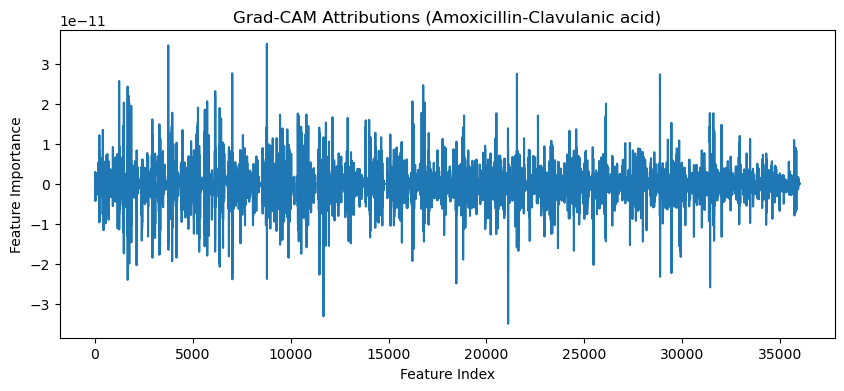

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


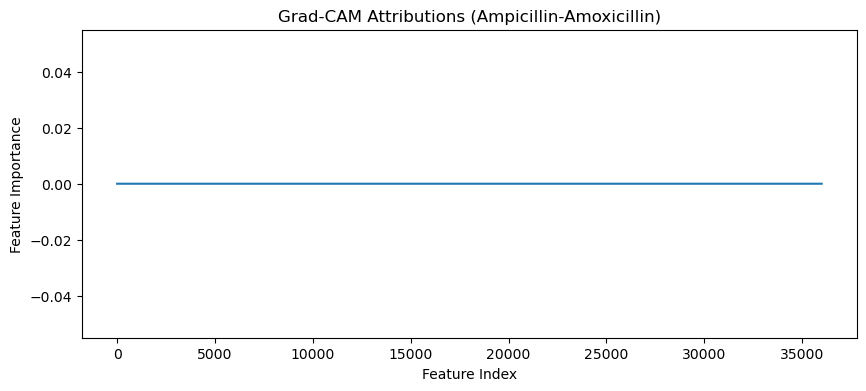

In [20]:
# Captum methods for combinatorial data
target_layer = model.backbone.conv2
    
for combination, sample_df in selected_samples.items():
    plotted = False
    for index, row in sample_df.iterrows():
        if plotted:
            break
            
        code = row['code']
        antibiotics = [antibiotic_columns[idx] for idx, val in enumerate(row[antibiotic_columns]) if val == 1]
        if not antibiotics:
            continue

        spectrum_data = load_spectrum_data(code)
        if spectrum_data is None:
            continue
        
        spectrum_data = torch.tensor(spectrum_data, dtype=torch.float).unsqueeze(0).unsqueeze(0)
        spectrum_data = spectrum_data.to(device)

        grad_cam = GuidedGradCam(model, layer=target_layer)
        
        for antibiotic in antibiotics:
            target_index = antibiotic_columns.index(antibiotic)
    
            gradcam_attributions = grad_cam.attribute(spectrum_data, target=target_index)
            print(gradcam_attributions)
    
            plot_attributions(gradcam_attributions, f'Grad-CAM Attributions ({antibiotic})')
        plotted = True
    

In [ ]:
plot_attributions(grad_cam_attr, 'Grad-CAM Attributions')

In [ ]:
wandb.finish()

In [34]:
# Correlation calculation
resistances = ["Ampicillin-Amoxicillin", #"Cefepime", 
               "Ceftazidime", "Ceftriaxone", #"Clindamycin", 
               "Erythromycin", "Fosfomycin-Trometamol",
               "Fusidic acid", "Gentamicin", "Imipenem", 
               "Levofloxacin", "Meropenem", "Penicillin", 
               "Rifampicin", "Tetracycline", "Tobramycin"]

resistance_counts = {key: 0 for key in resistances}

for file_path in csv_files:
    data = pd.read_csv(file_path)

    # Sum up occurrences for each resistance
    for antibiotic in resistances:
        if antibiotic in data.columns:
            resistance_counts[antibiotic] += data[antibiotic].sum()

for resistance, count in resistance_counts.items():
    print(f'{resistance}: {count}')

Ampicillin-Amoxicillin: 18126
Ceftazidime: 1869
Ceftriaxone: 5740
Erythromycin: 3695
Fosfomycin-Trometamol: 1140
Fusidic acid: 2803
Gentamicin: 1846
Imipenem: 5683
Levofloxacin: 3204
Meropenem: 4129
Penicillin: 7999
Rifampicin: 436
Tetracycline: 2547
Tobramycin: 1337


In [35]:
target_layer = model.backbone.conv2
grad_cam = GuidedGradCam(model, layer=target_layer)

attributions = {}

for antibiotic, sample in selected_samples.items():
    if antibiotic in resistances:
        print(antibiotic)
        spectrum_data = load_spectrum_data(sample['code'])
        spectrum_data = torch.tensor(spectrum_data).unsqueeze(0).unsqueeze(0)
        spectrum_data = spectrum_data.to(device)

        target_index = antibiotic_columns.index(antibiotic)

        attribution = grad_cam.attribute(spectrum_data, target=target_index)

        attributions[antibiotic] = attribution.cpu().detach().numpy().mean()

print(attributions)

Tetracycline


/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rfreund/miniforge3/envs/amr/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Rifampicin
Levofloxacin
Tobramycin
Ampicillin-Amoxicillin
Ceftriaxone
Penicillin
Fosfomycin-Trometamol
Imipenem
Gentamicin
Fusidic acid
Meropenem
Ceftazidime
Erythromycin
{'Tetracycline': -2.7592926e-38, 'Rifampicin': -2.0492374e-28, 'Levofloxacin': -1.2909183e-31, 'Tobramycin': 1.7991613e-14, 'Ampicillin-Amoxicillin': 9.003751e-12, 'Ceftriaxone': -7.9639305e-14, 'Penicillin': 1.0259116e-12, 'Fosfomycin-Trometamol': -5.108604e-27, 'Imipenem': -3.4374447e-17, 'Gentamicin': -1e-45, 'Fusidic acid': -5.538858e-38, 'Meropenem': 1.3777653e-32, 'Ceftazidime': -3.5052697e-22, 'Erythromycin': 2.0013951e-16}


In [36]:
counts = [resistance_counts[antibiotic] for antibiotic in attributions.keys()]
importance_values = [attributions[antibiotic] for antibiotic in attributions.keys()]

pearson_corr, _ = pearsonr(counts, importance_values)
spearman_corr, _ = spearmanr(counts, importance_values)

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: 0.9130717164610967
Spearman Correlation: 0.24395604395604395


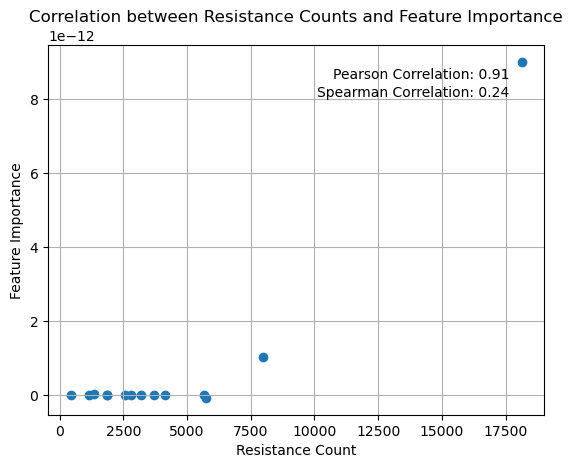

In [37]:
plt.scatter(counts, importance_values)
plt.title('Correlation between Resistance Counts and Feature Importance')
plt.xlabel('Resistance Count')
plt.ylabel('Feature Importance')
plt.grid(True)

plt.annotate(f'Pearson Correlation: {pearson_corr:.2f}', (0.93, 0.94), xycoords='axes fraction', fontsize=10, ha='right', va='top')
plt.annotate(f'Spearman Correlation: {spearman_corr:.2f}', (0.93, 0.89), xycoords='axes fraction', fontsize=10, ha='right', va='top')

antibiotics_list = list(attributions.keys())  # Assuming this matches order in 'counts' and 'importance_values'
for i, antibiotic in enumerate(antibiotics_list):
    if antibiotic in ["Cefepime", "Clindamycin"]:
        plt.annotate(antibiotic, (counts[i], importance_values[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.savefig('/faststorage/project/amr_driams/rasmus/Figures/features/correlation_outliers_removed.png', dpi=300)
plt.show()